# Neural style transfer

Neural style transfer consists of **applying the style** of a reference image to a target image while **conserving the content** of the target image.
In this context, _style_ essentially means textures, colors, and visual patterns in the image, at various spatial scales; and the _content_ is the higher-level macrostructure of the image.

The key notion behind implementing style transfer is the same idea that’s central to all deep-learning algorithms: you define a loss function to specify what you want to achieve, and you minimize this loss. You know what you want to achieve: **conserving the content of the original image while adopting the style of the reference image**. If we were able to mathematically define content and style, then an appropriate loss func- tion to minimize would be the following:
```python
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```

## The content loss
As you already know, activations from earlier layers in a network contain local information about the image, while activations from higher layers contain increasingly global and abstract information. Formulated in a different way, the activations of the different layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Therefore we expect the "content" of an image, which is more global and more abstract, to be captured by the representations of a top layer of a convnet.

A good candidate for a content loss would thus be to consider a pre-trained convnet, and define as our loss the L2 norm between the activations of a top layer computed over the target image and the activations of the same layer computed over the generated image. This would guarantee that, as seen from the top layer of the convnet, the generated image will "look similar" to the original target image. Assuming that what the top layers of a convnet see is really the "content" of their input images, then this does work as a way to preserve image content.

## The style loss
While the content loss only leverages a single higher-up layer, the style loss as defined in the Gatys et al. paper leverages multiple layers of a convnet: we aim at capturing the appearance of the style reference image at all spatial scales extracted by the convnet, not just any single scale.

For the style loss, the Gatys et al. paper leverages the "Gram matrix" of a layer's activations, i.e. the inner product between the feature maps of a given layer. This inner product can be understood as representing a map of the correlations between the features of a layer. These feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically corresponds to the appearance of the textures found at this scale.

Hence the style loss aims at preserving similar internal correlations within the activations of different layers, across the style reference image and the generated image. In turn, this guarantees that the textures found at different spatial scales will look similar across the style reference image and the generated image.

-----

In short, we can use a pre-trained convnet to define a loss that will:

- Preserve content by maintaining similar high-level layer activations between the target content image and the generated image. The convnet should "see" both the target image and the generated image as "containing the same things".
- Preserve style by maintaining similar correlations within activations for both low-level layers and high-level layers. Indeed, feature correlations capture textures: the generated and the style reference image should share the same textures at different spatial scales.

## Implementing neural style transfer in Keras

Neural style transfer can be implemented using any pretrained convnet. This time we'll use the VGG19 network used by Gatys et al. VGG19 is a simple variant of the VGG16 net- work introduced in chapter 5, with three more convolutional layers.
This is the general process:
1.  Set up a network that computes VGG19 layer activations for the style-reference image, the target image, and the generated image at the same time.
2.  Use the layer activations computed over these three images to define the loss function described earlier, which you’ll minimize in order to achieve style transfer.
3.  Set up a gradient-descent process to minimize this loss function.

### Setup and imports

In [48]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

### Visualize the input

In [17]:
MAX_DIM = 512
content_path = './resources/riva.jpg'
style_path = './resources/kandinsky_style.jpg'

# Get an image and read it into a NumPy array.
def get_image(path_to_img, max_dim=MAX_DIM):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    
    return img

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(image, title=None):
    plt.clf()
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

# Transform a tensor to an image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
    tensor = tensor[0]   
    return PIL.Image.fromarray(tensor)

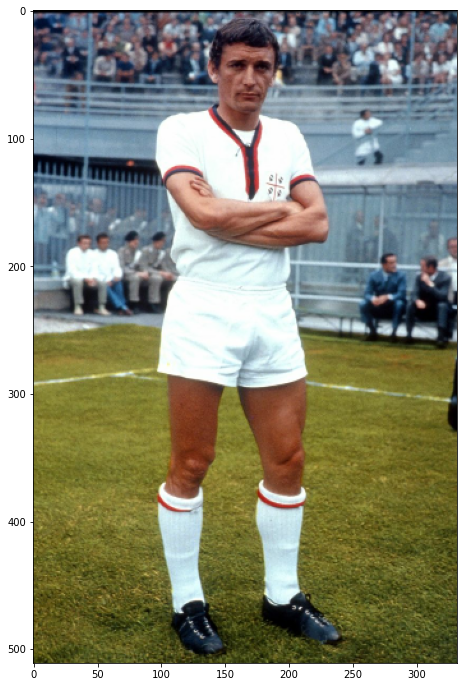

In [18]:
content_image = get_image(content_path)
show(content_image)

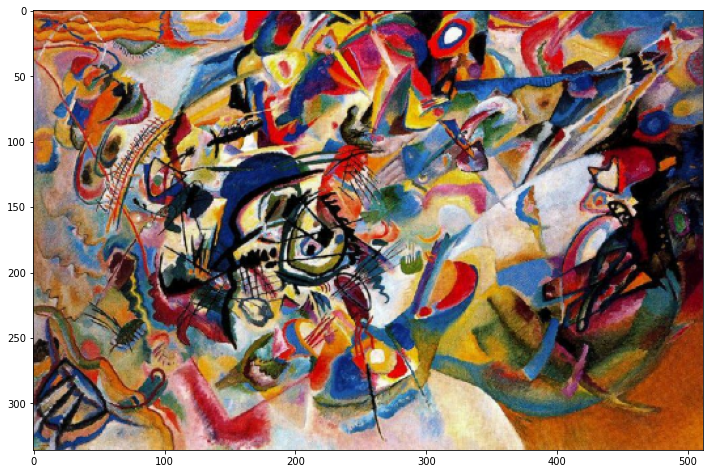

In [19]:
style_image = get_image(style_path)
show(style_image)

### Setup the network

In [20]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#### Intermediate layers for style and content

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, we'll be able to describe the content and style of input images.

In [21]:
content_layers = ['block5_conv2'] 
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1', 
    'block4_conv1', 
    'block5_conv1'
]

### Build the model

This function builds a `VGG19` model that returns a list of intermediate layer outputs:

In [22]:
def vgg_model(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg_net = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_net.trainable = False

    outputs = [vgg_net.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg_net.input], outputs)
    
    return model

In [23]:
style_extractor = vgg_model(style_layers)
style_outputs = style_extractor(style_image * 255)

### Extract style and content

The style of an image can be described by the means and correlations across the different feature maps. All we need is to calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations:

In [26]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    
    return result / (num_locations)

Build a model that returns the style and content tensors. When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [30]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [31]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.049184985
    max:  26949.85
    mean:  519.34784

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  96496.98
    mean:  16993.355

   block3_conv1
    shape:  (1, 256, 256)
    min:  3.9301174
    max:  380533.56
    mean:  17827.291

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3757181.8
    mean:  241145.47

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  134831.12
    mean:  2676.571

Contents:
   block5_conv2
    shape:  (1, 31, 20, 512)
    min:  0.0
    max:  2415.4072
    mean:  19.236696


### Run gradient descent

With this style and content extractor, we can now implement the style transfer algorithm. We can do that by calculating the mean square error for the image's output relative to each target, then take the weighted sum of these losses.

In [32]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Now we can define a `tf.Variable` to contain the image to optimize. To make this quick, we can **initialize it with the content image** (the `tf.Variable` must be the same shape as the content image):

In [33]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [34]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [35]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [43]:
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    num_style_layers = len(style_layers)
    num_content_layers = len(content_layers)
    
    style_loss = tf.add_n(
        [tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
         for name in style_outputs.keys()]
    )
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n(
        [tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
         for name in content_outputs.keys()]
    )
    
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    
    return loss

Now we can use `tf.GradientTape` to update the image.

In [44]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In order to check if this works, let's run a few steps:

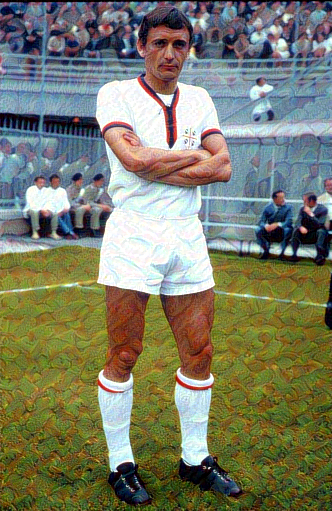

In [45]:
train_step(image)
train_step(image)
train_step(image)

tensor_to_image(image)

It seems to work, so let's perform a longer optimization:

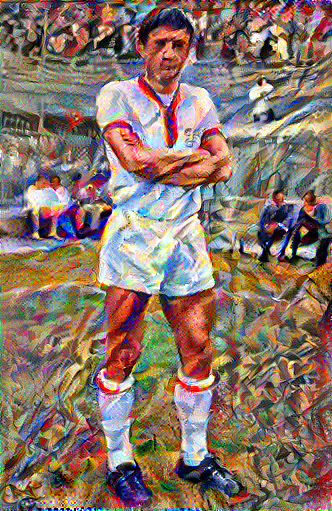

Train step: 1000
Total time: 1804.4


In [49]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

for epoch in range(epochs):
    print(f"Epoch: {(epoch + 1)}/{epochs}".format(step))
    for step in range(steps_per_epoch):
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
  
end = time.time()

print("Total time: {:.1f}".format(end-start))

What this technique achieves is merely a form of **image retexturing**, or **texture transfer**. It works best with style-reference images that are strongly textured and highly self-similar, and with content targets that don’t require high levels of detail in order to be recognizable. It **typically can’t achieve fairly abstract feats such as transferring the style of one portrait to another**. The algorithm is closer to classical signal processing than to AI, so don’t expect it to work like magic!